In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

In [9]:
data_folder = "data"
web_data = "web_page_data.csv"

In [10]:
session_times = pd.read_csv(Path(data_folder) / web_data)
session_times.loc[:, 'Time'] *= 100.

In [11]:
session_times.tail()

,Page,Time
31,Page A,74.0
32,Page A,86.0
33,Page A,118.0
34,Page A,206.0
35,Page A,93.0


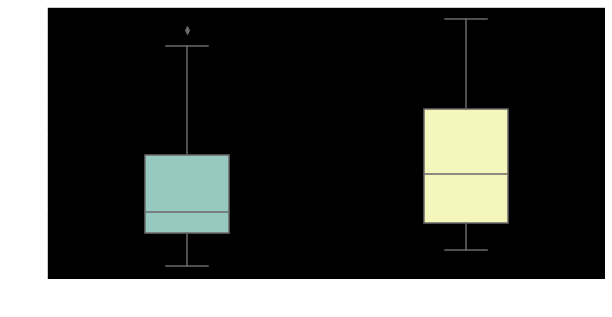

In [12]:
plt.subplots(figsize=(10, 5))
sns.boxplot(x='Page', y='Time', data=session_times, width=0.3)